In [123]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl
import pandas as pd
from sklearn.preprocessing import StandardScaler

# print the JS visualization code to the notebook
shap.initjs()

In [124]:
# Load TCGA RNA-seq data
df = pd.read_csv("../../data/breast_cancer/BRCA_U133A.csv", index_col=0)
print(df.shape)

(474, 13397)


In [125]:
all_genes = list( df.columns[0:13394].values )
genes = all_genes
#print(all_genes[5550:5570])

In [126]:
# Get subset: 
# train data
#X = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532"]), genes]
#y = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532"]), "Class"]
#X = df.loc[df["Dataset"].isin(["GSE12093", "GSE17705", "GSE1456"]), genes]
#y = df.loc[df["Dataset"].isin(["GSE12093", "GSE17705", "GSE1456"]), "Class"]
#X = df.loc[df["Dataset"].isin(["GSE6532","GSE12093", "GSE17705", "GSE1456"]), genes]
#y = df.loc[df["Dataset"].isin(["GSE6532","GSE12093", "GSE17705", "GSE1456"]), "Class"]
X = df.loc[df["Dataset"].isin(["GSE3494","GSE6532","GSE12093", "GSE17705", "GSE1456"]), genes]
y = df.loc[df["Dataset"].isin(["GSE3494","GSE6532","GSE12093", "GSE17705", "GSE1456"]), "Class"]
print("X - {}; y - {}".format(X.shape, y.shape))

# Do scaling 
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

X - (474, 13394); y - (474,)


In [165]:
# create a train/test split
seed_val = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_val)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [168]:
# Train the model
params = {
    "eta": 0.001,
    "objective": "binary:logistic",
    "subsample": 0.6,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
    #"seed": seed_val,
}
model = xgboost.train(params, 
                      d_train, 
                      5000,
                      evals = [(d_test, "test")], 
                      verbose_eval=100, 
                      early_stopping_rounds=20)

[0]	test-logloss:0.59855
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.58653
[200]	test-logloss:0.57671
[300]	test-logloss:0.56944
[400]	test-logloss:0.56186
[500]	test-logloss:0.55726
[600]	test-logloss:0.55236
[700]	test-logloss:0.54858
[800]	test-logloss:0.54430
[900]	test-logloss:0.54259
Stopping. Best iteration:
[908]	test-logloss:0.54247



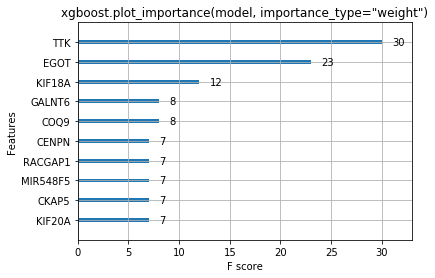

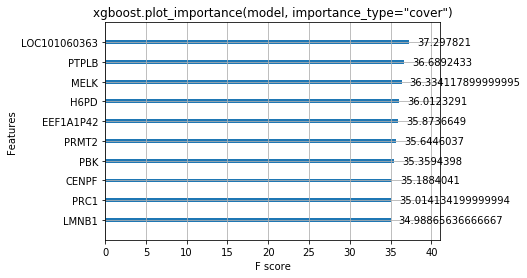

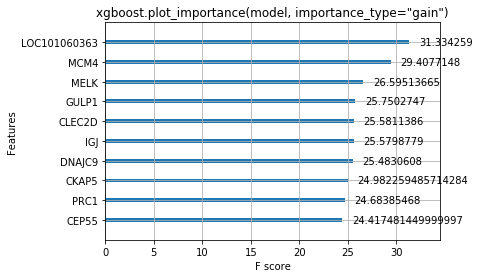

In [155]:
#
xgboost.plot_importance(model, importance_type="weight", max_num_features=10)
pl.title('xgboost.plot_importance(model, importance_type="weight")')
pl.show()
xgboost.plot_importance(model, importance_type="cover",  max_num_features=10)
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()
xgboost.plot_importance(model, importance_type="gain",  max_num_features=10)
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [156]:
# calculate SHAP-values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

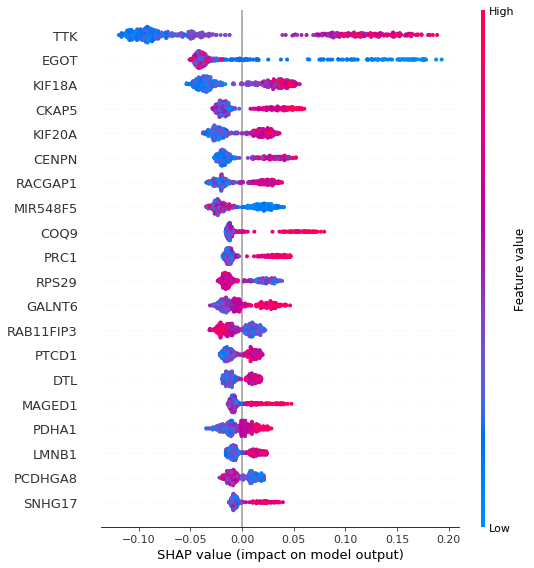

In [157]:
shap.summary_plot(shap_values, X)

In [138]:
shap_values.shape

(474, 13394)

In [152]:
#avg_shap_values = np.ndarray((shap_values.shape[0],),float)
avg_shap_values = {}
for i in range( shap_values.shape[1] ):
    col_name = X.columns.values[i]
    avg_shap_values[col_name] = abs(shap_values[:,i]).mean()
#print(avg_shap_values)
imp_type='shap'
fmap=avg_shap_values
f = open("genes_by_" + imp_type + ".txt",'w')
for key, value in sorted(fmap.items(), key=lambda x: x[1], reverse=True): 
    print("{} : {}".format(key, value), file=f)    
f.close()

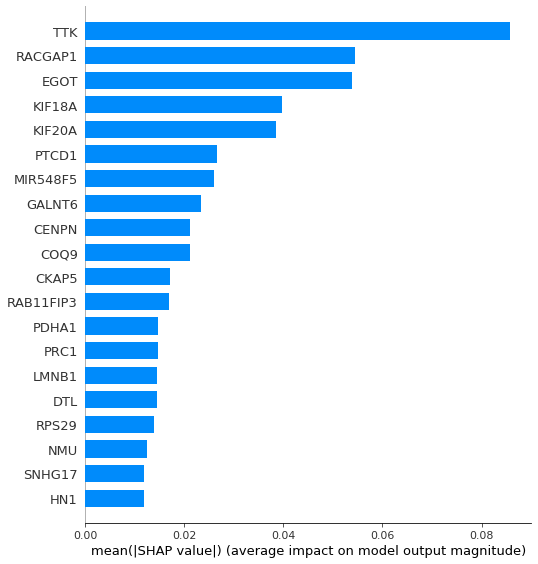

In [153]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [43]:
# save list to file
imp_type='cover'
fmap=model.get_score(importance_type=imp_type)

f = open("genes_by_" + imp_type + ".txt",'w')

for key, value in sorted(fmap.items(), key=lambda x: x[1], reverse=True): 
    print("{} : {}".format(key, value), file=f)
    
f.close()

In [55]:
#list(X.columns.values)
shap_values[1,:].mean()

-0.00054141646